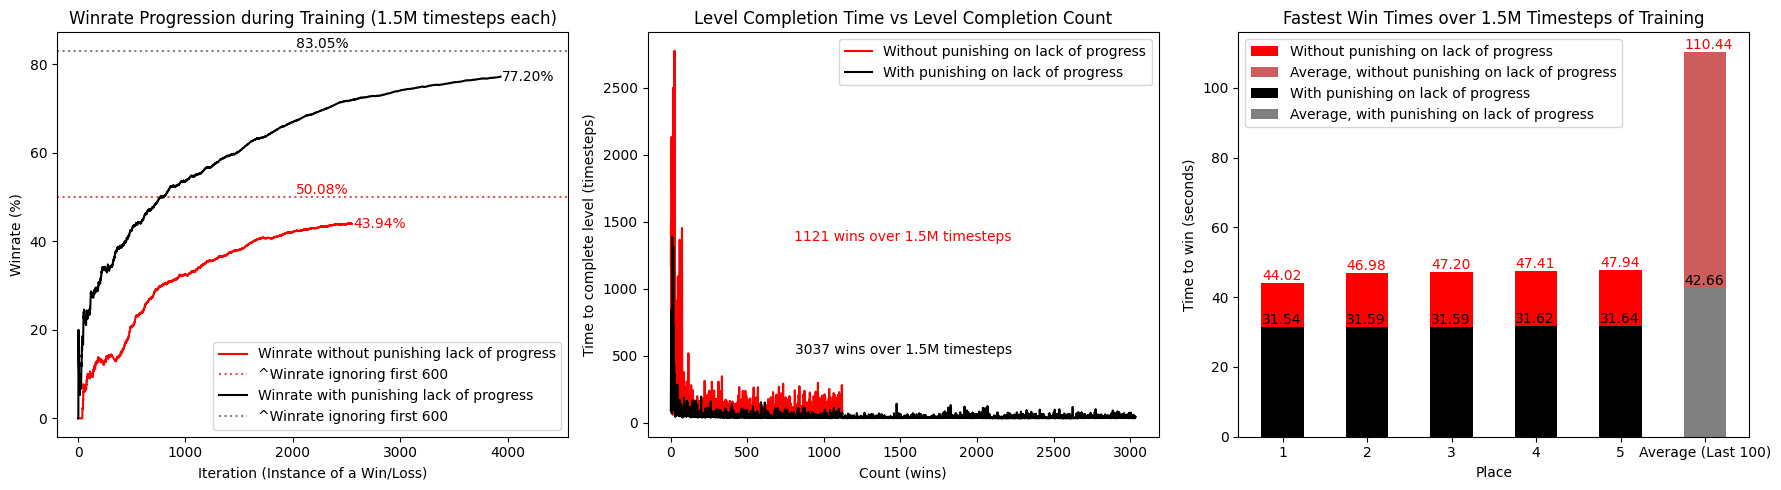

In [15]:
from typing import final
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80  # estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color, append=""):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 100.0, yval, f'{yval:.2f}{append}', va='bottom', color=color)

def process_winloss(winloss, ignore_phase):
    p1_iter_wins, p2_iter_wins, p3_iter_wins, total_wins = 0, 0, 0, 0
    p1_iter_losses, p2_iter_losses, p3_iter_losses, total_losses = 0, 0, 0, 0
    p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses = [], [], [], []
    p1_iter_wins_ignore, p2_iter_wins_ignore, p3_iter_wins_ignore = 0, 0, 0
    p1_iter_losses_ignore, p2_iter_losses_ignore, p3_iter_losses_ignore = 0, 0, 0
    p1_iter_winlosses_ignore, p2_iter_winlosses_ignore, p3_iter_winlosses_ignore = [], [], []
    for index, row in winloss.iterrows():
        if row['WinLoss'] == 'win':
            if row['Pass'] == 1:
                p1_iter_wins += 1
                if index >= ignore_phase:
                    p1_iter_wins_ignore += 1
            elif row['Pass'] == 2:
                p2_iter_wins += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses:
                    p2_iter_wins_ignore += 1
            elif row['Pass'] == 3:
                p3_iter_wins += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses + p2_iter_wins + p2_iter_losses:
                    p3_iter_wins_ignore += 1
            total_wins += 1
        elif row['WinLoss'] == 'loss':
            if row['Pass'] == 1:
                p1_iter_losses += 1
                if index >= ignore_phase:
                    p1_iter_losses_ignore += 1
            elif row['Pass'] == 2:
                p2_iter_losses += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses:
                    p2_iter_losses_ignore += 1
            elif row['Pass'] == 3:
                p3_iter_losses += 1
                if index >= ignore_phase + p1_iter_wins + p1_iter_losses + p2_iter_wins + p2_iter_losses:
                    p3_iter_losses_ignore += 1
            total_losses += 1
        if (p1_iter_wins + p1_iter_losses) > 0 and row['Pass'] == 1:
            p1_iter_winlosses.append(p1_iter_wins / (p1_iter_wins + p1_iter_losses) * 100)
        if (p2_iter_wins + p2_iter_losses) > 0 and row['Pass'] == 2:
            p2_iter_winlosses.append(p2_iter_wins / (p2_iter_wins + p2_iter_losses) * 100)
        if (p3_iter_wins + p3_iter_losses) > 0 and row['Pass'] == 3:
            p3_iter_winlosses.append(p3_iter_wins / (p3_iter_wins + p3_iter_losses) * 100)
        if (p1_iter_wins_ignore + p1_iter_losses_ignore) > 0 and row['Pass'] == 1:
            p1_iter_winlosses_ignore.append(p1_iter_wins_ignore / (p1_iter_wins_ignore + p1_iter_losses_ignore) * 100)
        if (p2_iter_wins_ignore + p2_iter_losses_ignore) > 0 and row['Pass'] == 2:
            p2_iter_winlosses_ignore.append(p2_iter_wins_ignore / (p2_iter_wins_ignore + p2_iter_losses_ignore) * 100)
        if (p3_iter_wins_ignore + p3_iter_losses_ignore) > 0 and row['Pass'] == 3:
            p3_iter_winlosses_ignore.append(p3_iter_wins_ignore / (p3_iter_wins_ignore + p3_iter_losses_ignore) * 100)
        if (total_wins + total_losses) > 0:
            total_iter_winlosses.append(total_wins / (total_wins + total_losses) * 100)
    
    final_p1 = p1_iter_winlosses[-1] if p1_iter_winlosses else 0
    final_p2 = p2_iter_winlosses[-1] if p2_iter_winlosses else 0
    final_p3 = p3_iter_winlosses[-1] if p3_iter_winlosses else 0
    final_overall = total_iter_winlosses[-1] if total_iter_winlosses else 0
    final_p1_ignore = p1_iter_winlosses_ignore[-1] if p1_iter_winlosses_ignore else 0
    final_p2_ignore = p2_iter_winlosses_ignore[-1] if p2_iter_winlosses_ignore else 0
    final_p3_ignore = p3_iter_winlosses_ignore[-1] if p3_iter_winlosses_ignore else 0

    return (p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses,
            final_p1, final_p2, final_p3, final_overall,
            final_p1_ignore, final_p2_ignore, final_p3_ignore)

def process_levelbeats(levelbeats_path, cutoff):
    levelbeats = pd.read_csv(levelbeats_path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])
    
    with open(levelbeats_path, 'r') as file:
        lines = file.readlines()
    try:
        split_index = lines.index('\n')
    except:
        split_index = len(levelbeats['completion_timesteps'])
    
    p_completion_t = levelbeats['completion_timesteps']
    p_training_t = levelbeats['training_timesteps']
    average_pass = convert_to_time(p_completion_t[-cutoff:].mean())
    fastest_pass = levelbeats[:split_index].nsmallest(5, 'completion_timesteps')
    
    return p_completion_t, p_training_t, average_pass, fastest_pass

def main():
    ignore_phase = 600
    cutoff = 100
    p_colors = {1: ("red", "indianred"), 3: ("black", "gray")}

    winloss_paths = {1: './logs/winloss pass1only.csv', 3: './logs/winloss pass3only.csv'}
    levelbeats_paths = {1: './logs/levelbeats pass1only.csv', 3: './logs/levelbeats pass3only.csv'}

    data = {}
    for p in ps:
        winloss = pd.read_csv(winloss_paths[p], header=None, names=['WinLoss', 'Pass'])
        (p1_iter_winlosses, p2_iter_winlosses, p3_iter_winlosses, total_iter_winlosses,
        final_p1, final_p2, final_p3, final_overall,
        final_p1_ignore, final_p2_ignore, final_p3_ignore) = process_winloss(winloss, ignore_phase)
        
        p_completion_t, p_training_t, average_pass, fastest_pass = process_levelbeats(levelbeats_paths[p], cutoff)
        
        data[p] = {
            "p1_iter_winlosses": p1_iter_winlosses,
            "p2_iter_winlosses": p2_iter_winlosses,
            "p3_iter_winlosses": p3_iter_winlosses,
            "total_iter_winlosses": total_iter_winlosses,
            "final_p1": final_p1,
            "final_p2": final_p2,
            "final_p3": final_p3,
            "final_overall": final_overall,
            "final_p1_ignore": final_p1_ignore,
            "final_p2_ignore": final_p2_ignore,
            "final_p3_ignore": final_p3_ignore,
            "p_completion_t": p_completion_t,
            "p_training_t": p_training_t,
            "average_pass": average_pass,
            "fastest_pass": fastest_pass
        }

    fig = plt.figure(figsize=(18, 5))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1], height_ratios=[1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    # ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[2])

    ax0.set_title('Winrate Progression during Training (1.5M timesteps each)')
    ax0.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax0.set_ylabel('Winrate (%)')

    for p in ps:
        color, color_average = p_colors[p]
        mid_index = len(data[3]["p3_iter_winlosses"]) // 2
        if p == 1:
            ax0.plot(data[p]["p1_iter_winlosses"], color=color, label='Winrate without punishing lack of progress')
            ax0.annotate(f'{data[p]["final_p1"]:.2f}%', xy=(len(data[p]["p1_iter_winlosses"]) - 1, data[p]["final_p1"] - 1), xytext=(1, 0), textcoords='offset points', color=color)
            ax0.axhline(data[p]["final_p1_ignore"], color=color_average, linestyle='dotted', label=f'^Winrate ignoring first {ignore_phase}')
            ax0.annotate(f'{data[p]["final_p1_ignore"]:.2f}%', xy=(mid_index, data[p]["final_p1_ignore"]), xytext=(5, 2), textcoords='offset points', color=color, fontsize=10)
        elif p == 3:
            ax0.plot(data[p]["p3_iter_winlosses"], color=color, label='Winrate with punishing lack of progress')
            ax0.annotate(f'{data[p]["final_p3"]:.2f}%', xy=(len(data[p]["p3_iter_winlosses"]) - 1, data[p]["final_p3"] - 1), xytext=(1, 0), textcoords='offset points', color=color)
            ax0.axhline(data[p]["final_p3_ignore"], color=color_average, linestyle='dotted', label=f'^Winrate ignoring first {ignore_phase}')
            ax0.annotate(f'{data[p]["final_p3_ignore"]:.2f}%', xy=(mid_index, data[p]["final_p3_ignore"]), xytext=(5, 2), textcoords='offset points', color=color, fontsize=10)

    for ax in [ax0]:
        x_left, x_right = ax.get_xlim()
        padding = (x_right - x_left) * 0.1  # 10% right padding
        ax.set_xlim(x_left, x_right + padding)
        ax.legend()

    width = 0.5

    for p in ps:
        color, color_average = p_colors[p]
        indices_pass = range(len(data[p]["fastest_pass"]))
        if p == 1:
            ax1.plot(convert_to_time(data[p]["p_completion_t"]), color=color, label='Without punishing on lack of progress')
            ax1.text(len(data[3]["p_completion_t"]) // 2, max(convert_to_time(data[p]["p_completion_t"])) // 2, f'{len(data[p]["p_completion_t"])} wins over 1.5M timesteps', color=color, verticalalignment='center', horizontalalignment='center')
            # ax2.plot(data[p]["p_training_t"], convert_to_time(data[p]["p_completion_t"]), linestyle='--', marker='.', label=f'Without punishing on lack of progress', color=color)
            bars = ax3.bar(indices_pass, convert_to_time(data[p]["fastest_pass"]['completion_timesteps']), width=width, label=f'Without punishing on lack of progress', color=color)
            bars_avg = ax3.bar([max(indices_pass) + 1], [data[p]["average_pass"]], width=width, label=f'Average, without punishing on lack of progress', color=color_average)
        elif p == 3:
            ax1.plot(convert_to_time(data[p]["p_completion_t"]), color=color, label='With punishing on lack of progress')
            ax1.text(len(data[3]["p_completion_t"]) // 2, max(convert_to_time(data[3]["p_completion_t"])) // 2 - 150, f'{len(data[p]["p_completion_t"])} wins over 1.5M timesteps', color=color, verticalalignment='center', horizontalalignment='center')
            # ax2.plot(data[p]["p_training_t"], convert_to_time(data[p]["p_completion_t"]), linestyle='--', marker='.', label=f'With punishing on lack of progress', color=color)
            bars = ax3.bar(indices_pass, convert_to_time(data[p]["fastest_pass"]['completion_timesteps']), width=width, label=f'With punishing on lack of progress', color=color)
            bars_avg = ax3.bar([max(indices_pass) + 1], [data[p]["average_pass"]], width=width, label=f'Average, with punishing on lack of progress', color=color_average)
        ax1.set_title('Level Completion Time vs Level Completion Count')
        ax1.set_xlabel('Count (wins)')
        ax1.set_ylabel('Time to complete level (timesteps)')
        ax1.legend(loc='upper right')
        # if p == 1:
        #     ax2.set_title('Level Completion Time vs Training Timesteps')
        #     ax2.set_xlabel('Training Timesteps (1.5M Total)')
        #     ax2.set_ylabel('Time to complete level (timesteps)')
        # ax2.legend(loc='upper right')


        label_bars(ax3, bars, color)
        label_bars(ax3, bars_avg, color)
        ax3.set_xticks(list(indices_pass) + [max(indices_pass) + 1])
        ax3.set_xticklabels(list(range(1, len(data[p]["fastest_pass"]) + 1)) + [f'Average (Last {cutoff})'])
        if p == 1:
            ax3.set_title('Fastest Win Times over 1.5M Timesteps of Training')
            ax3.set_ylabel('Time to win (seconds)')
            ax3.set_xlabel('Place')
        ax3.legend()

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

ps = [1,3]

if __name__ == '__main__':
    main()
